# **Data Modelling and Evaluation**

---

## Objectives

* Answer business requirement 2: 
    * The client seeks to predict whether a cherry leaf is healthy or infected with powdery mildew.

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* image shape embeddings

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file





## Additional Comments:

N/A


---

## 1. Set Data Directory and Import Libraries

---

Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import joblib


2024-02-18 11:49:29.562855: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:49:29.604804: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-18 11:49:29.606712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 11:49:30.861491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


---

## 2. Set working directory

---

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/Portfolio_5_Cherry_Leaves_Mildew')
print("Changed current directory to workspace.")

Changed current directory to workspace.


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/Portfolio_5_Cherry_Leaves_Mildew'

---

## 3. Set input directories (Train, Validation, Test)

---

Set train, validation and test paths.

In [5]:
base_dir = '/workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


---

## 4. Set output directory

---

* Set output directory

In [6]:
outputs_dir = '/workspace/Portfolio_5_Cherry_Leaves_Mildew'
version = 'v1'
file_path = os.path.join(outputs_dir, 'outputs', version)

* Function to automatically increment version

In [7]:
def increment_version(ver):
    base, num = ver[:-1], int(ver[-1])
    return f"{base}{num + 1}"

* Check if 'outputs' directory exists, if not, create it

In [8]:
if 'outputs' not in os.listdir(outputs_dir):
    os.makedirs(os.path.join(outputs_dir, 'outputs'))

---

## 5. Set label names

---

Set labels

In [9]:
labels = os.listdir(train_dir)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

## 6. Set image shape

---

Import saved image shape embedding

In [10]:
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(50, 50)

---

## Images distribution

---

Function to count number of images per set and label

In [11]:
def count_images_per_label(base_dir, folders, labels):
    df_freq = pd.DataFrame([])
    for folder in folders:
        for label in labels:
            num_images = len(os.listdir(os.path.join(base_dir, folder, label)))
            df_freq = pd.concat([df_freq, pd.Series(data={'Set': folder, 'Label': label, 'Count': num_images})], ignore_index=True)
            print(f"* {folder} - {label}: {num_images} images")
    return df_freq

Function to plot bar chart

In [13]:
import plotly.express as px

sets = ["train", "train", "test", "test", "validation", "validation"]
labels = ["healthy", "powdery_mildew", "healthy", "powdery_mildew", "healthy", "powdery_mildew"]
counts = [1472, 1472, 422, 422, 210, 210]

# Create the DataFrame
df_freq = pd.DataFrame({'Set': sets, 'Label': labels, 'Count': counts})

# Define colors
color_palette = {"healthy": "darkgreen", "powdery_mildew": "yellowgreen"}

fig = px.bar(df_freq, 
             x='Set', 
             y='Count', 
             color='Label',
             color_discrete_map=color_palette,
             title='Cherry Leaves Dataset',
             text_auto=True
            )

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'outputs/{version}/bar_chart.png')


Function to plot pie chart

In [14]:
def plot_pie_chart(df):
    fig = plt.figure(figsize=(8, 8))
    plt.pie(df['Count'], labels=df['Set'], autopct='%1.1f%%', colors=['blue', 'green', 'orange'])
    plt.title('Dataset Split')
    plt.savefig(f'f"outputs/{version}/pie_chart.png', bbox_inches='tight', dpi=150)
    plt.show()


---

## 7. Image augmentation

---

In [15]:
# Import imagedatagenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialising the function

In [16]:
augmented_dataset = ImageDataGenerator(rotation_range=10,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

Augmenting training dataset

In [17]:
batch_size = 15 # running batch of 15 at a time
train_data_set = augmented_dataset.flow_from_directory(train_dir,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_data_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmentaing test dataset

In [18]:
test_data_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_data_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augmenting validation dataset

In [19]:
validation_data_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_data_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plotting augmented train images

(15, 50, 50, 3)


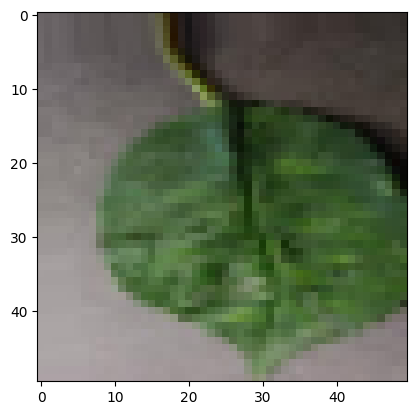

(15, 50, 50, 3)


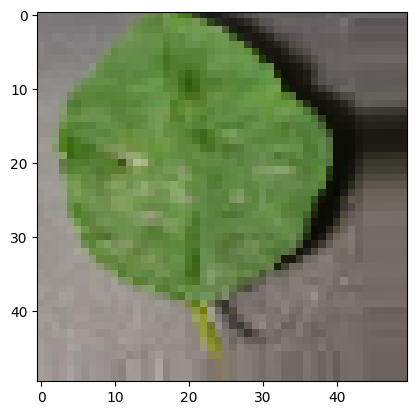

(15, 50, 50, 3)


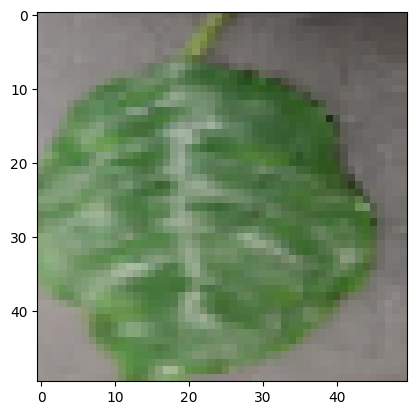

(15, 50, 50, 3)


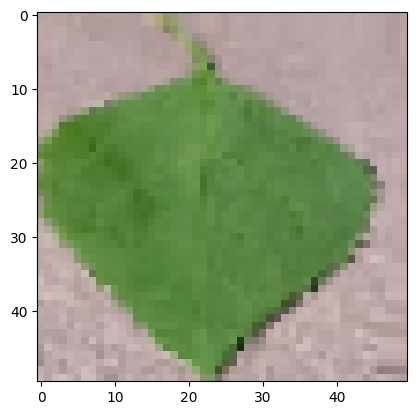

(15, 50, 50, 3)


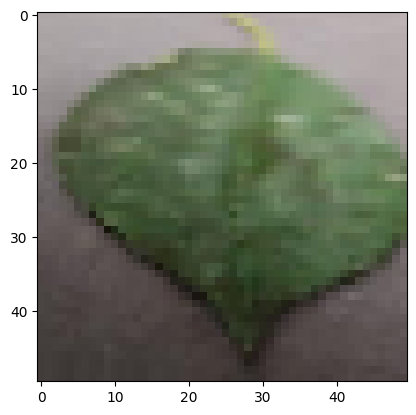

In [20]:
for _ in range(5):
    img, label = train_data_set.next()
    print(img.shape) #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

Plotting augmented test images

(15, 50, 50, 3)


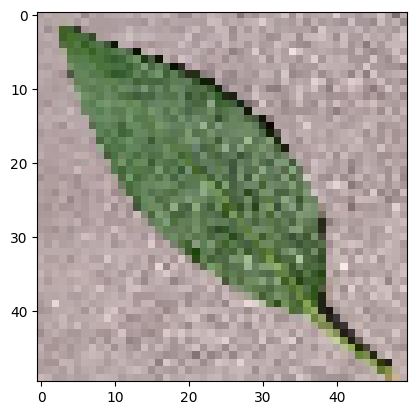

(15, 50, 50, 3)


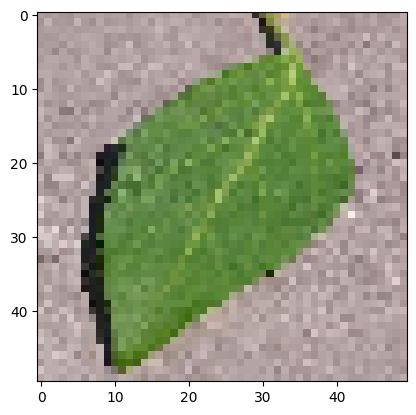

(15, 50, 50, 3)


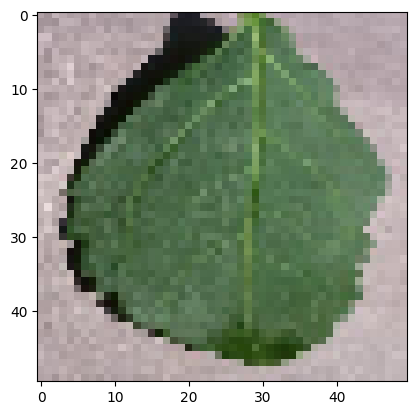

(15, 50, 50, 3)


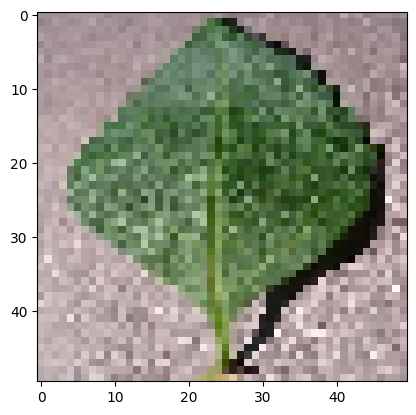

(15, 50, 50, 3)


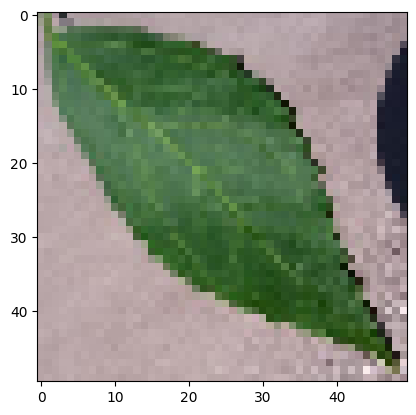

In [21]:
for _ in range(5):
    img, label = test_data_set.next()
    print(img.shape)  #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

Plotting validation test images

(15, 50, 50, 3)


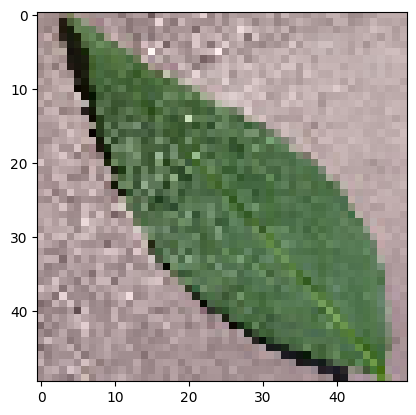

(15, 50, 50, 3)


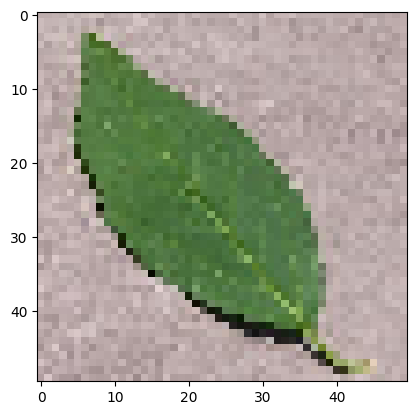

(15, 50, 50, 3)


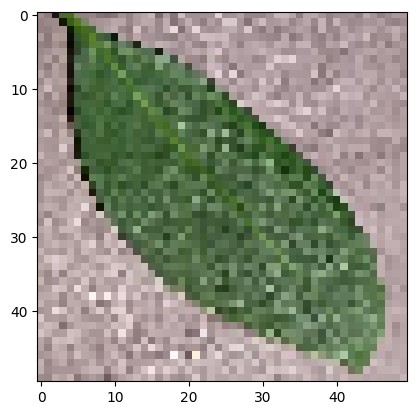

(15, 50, 50, 3)


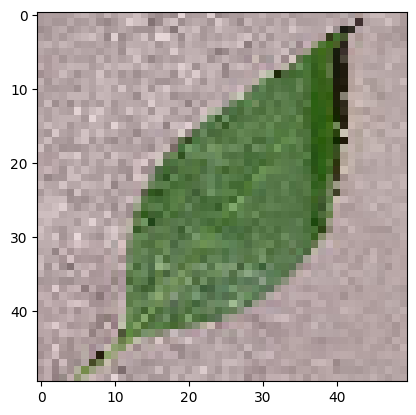

(15, 50, 50, 3)


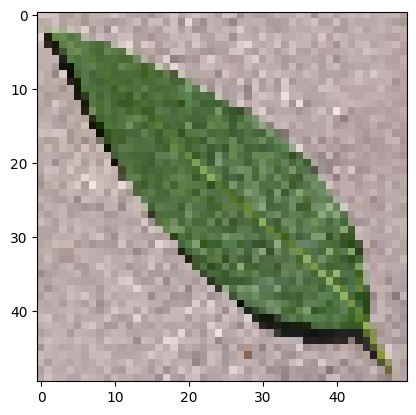

In [22]:
for _ in range(5):
    img, label = validation_data_set.next()
    print(img.shape)  #  (batch_size,h,w,rgb)
    plt.imshow(img[0])
    plt.show()

---

## 8. Save Class Indices

---

In [24]:
class_indices = train_data_set.class_indices 
joblib.dump(class_indices, f'outputs/{version}/class_indices.pkl')

['outputs/v1/class_indices.pkl']

---

## 9. Machine Learning Model Creation

---

### ML Model

In [25]:
def create_ml_model(image_shape):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

Model Summary

In [26]:

image_shape = (50, 50, 3)  # Example image shape

# Create the model
model = create_ml_model(image_shape)

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 64)          0

Callback - Early Stoppage Define a call back functioin to monitor accuracy of 99% 

In [27]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print(" \n Reached 99% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [28]:
model = create_ml_model(image_shape)
model.fit(train_data_set,
          epochs=20,
          steps_per_epoch=len(train_data_set.classes) // batch_size,
          validation_data=validation_data_set,
          callbacks=[callbacks],
          verbose=1
          )

Epoch 1/20
196/196 [==============================] - 9s 42ms/step - loss: 0.3718 - accuracy: 0.8201 - val_loss: 0.1205 - val_accuracy: 0.9452
Epoch 2/20
196/196 [==============================] - 8s 42ms/step - loss: 0.1317 - accuracy: 0.9536 - val_loss: 0.0290 - val_accuracy: 0.9929
Epoch 3/20
196/196 [==============================] - 15s 76ms/step - loss: 0.0746 - accuracy: 0.9737 - val_loss: 0.0162 - val_accuracy: 0.9929
Epoch 4/20
196/196 [==============================] - 15s 77ms/step - loss: 0.0622 - accuracy: 0.9795 - val_loss: 0.2025 - val_accuracy: 0.9262
Epoch 5/20
196/196 [==============================] - 8s 39ms/step - loss: 0.0451 - accuracy: 0.9846 - val_loss: 0.0298 - val_accuracy: 0.9833
Epoch 6/20
195/196 [============================>.] - ETA: 0s - loss: 0.0345 - accuracy: 0.9931 
 Reached 99% accuracy so cancelling training!
196/196 [==============================] - 7s 36ms/step - loss: 0.0347 - accuracy: 0.9928 - val_loss: 0.0026 - val_accuracy: 0.9976


Saving the model

In [29]:
model.save(f'outputs/{version}/mildew_detection_model.h5')

/workspace/.pyenv_mirror/user/current/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



---

## 11. Model Performace Metrics and Evaluation

---

Learning Curve

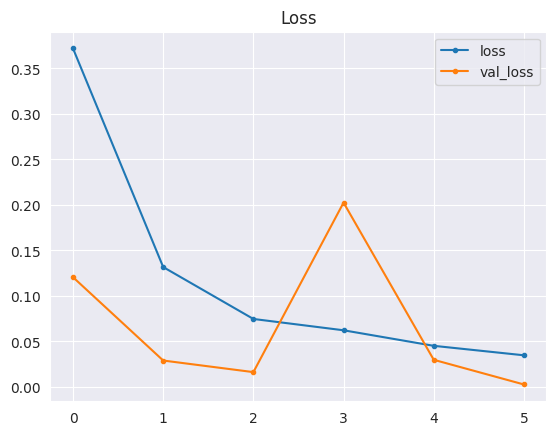

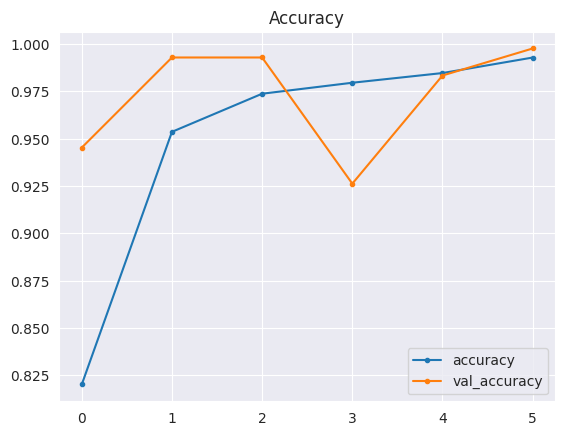

In [30]:
loss = pd.DataFrame(model.history.history)

sns.set_style("darkgrid")
loss[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
loss[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

Model Evaluation on Test Data

In [33]:
model = load_model(f'outputs/{version}/best_model.h5')
evaluation = model.evaluate(test_data_set)
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

57/57 [==============================] - 1s 16ms/step - loss: 0.0583 - accuracy: 0.9870
Test Loss: 0.058345187455415726
Test Accuracy: 0.9869668483734131


Save evaluation pickle

In [35]:
joblib.dump(value=evaluation ,
            filename=f'outputs/{version}/evaluation.pkl')

['outputs/v1/evaluation.pkl']

In [36]:
test_predictions = model.predict(test_data_set)
test_predictions_binary = np.where(test_predictions > 0.5, 1, 0)

57/57 [==============================] - 2s 34ms/step


Classification Report

In [37]:
print("Classification Report:")
print(classification_report(test_data_set.classes, test_predictions_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       422
           1       1.00      0.98      0.99       422

    accuracy                           0.99       844
   macro avg       0.99      0.99      0.99       844
weighted avg       0.99      0.99      0.99       844



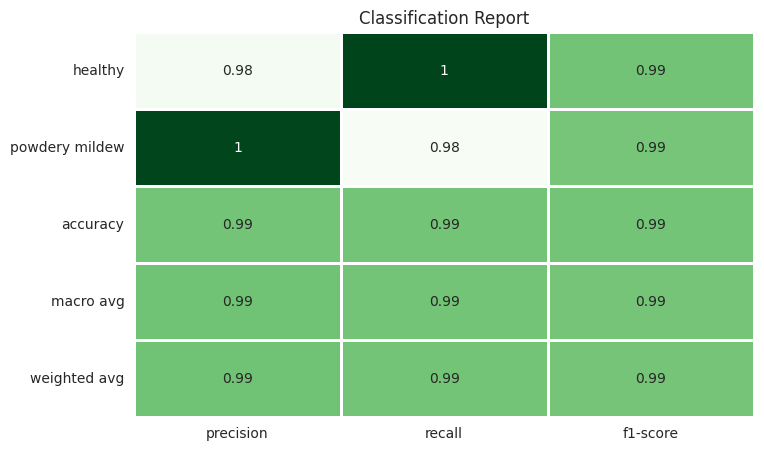

In [39]:
import matplotlib as mpl
target_names = ['healthy', 'powdery mildew']
clf_report = classification_report(test_data_set.classes, test_predictions_binary, output_dict=True, target_names=target_names)
fig, ax = plt.subplots(figsize=(8,5))
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="Greens", cbar=False, linewidths=1)
plt.title('Classification Report')
plt.savefig(f'outputs/{version}/classification_report.png')

# Confusion Matrix

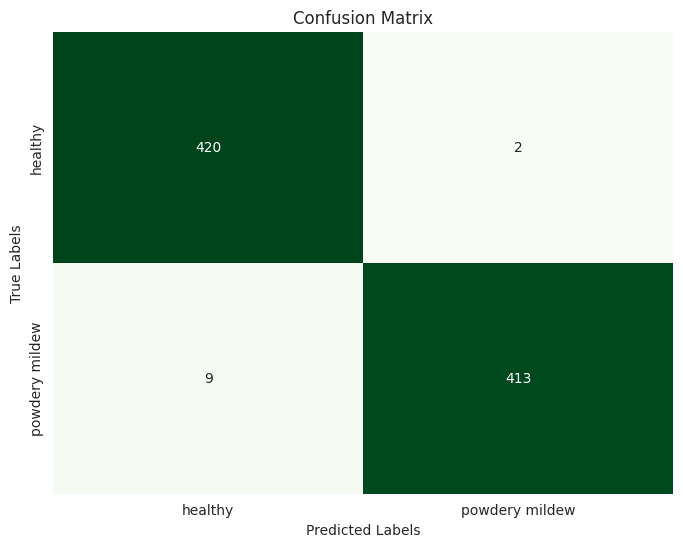

In [40]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(test_data_set.classes, test_predictions_binary)

# Define class labels
class_labels = ['healthy', 'powdery mildew']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(f"outputs/{version}/confusion_matrix.png")
plt.show()

# ROC Curve and AUC

57/57 [==============================] - 1s 11ms/step


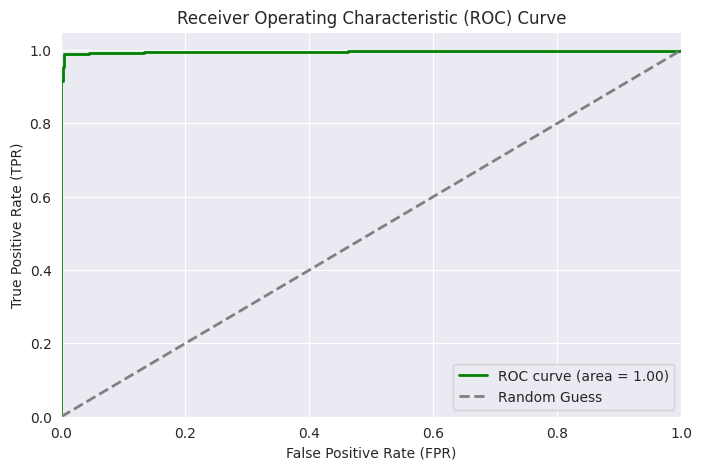

In [41]:
from sklearn.metrics import roc_curve, auc

# Make predictions on the test set
pred = model.predict(test_data_set)

# Calculate FPR, TPR, and classification thresholds
fpr, tpr, thresholds = roc_curve(test_data_set.classes, pred)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='green', lw=2,
         label=f'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2,
         linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig(f'{file_path}/roc_curve.png', bbox_inches='tight', dpi=150)

---

## 12. Prediction on a Random Image File

---

* Load a random image as PIL

In [42]:
import random
from tensorflow.keras.preprocessing import image

# Select a random label from the 'labels' list
random_label = random.choice(labels)

# Construct the path for the chosen label
label_dir = os.path.join(test_dir, random_label)

# Get a list of all files in the chosen label directory
files_in_label_dir = os.listdir(label_dir)

# Select a random file from the list of files
random_file = random.choice(files_in_label_dir)

# Construct the full path for the randomly selected image
image_path = os.path.join(label_dir, random_file)

# Load the image
pil_image = image.load_img(image_path, target_size=image_shape, color_mode='rgb')

print(f'Randomly selected label: {random_label}')
print(f'Image path: {image_path}')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')



Randomly selected label: healthy
Image path: /workspace/Portfolio_5_Cherry_Leaves_Mildew/inputs/cherry_leaves_dataset/cherry-leaves/test/healthy/76e3298c-998d-4bce-956a-f8812315e1d6___JR_HL 3979.JPG
Image shape: (50, 50), Image mode: RGB


* Display the image

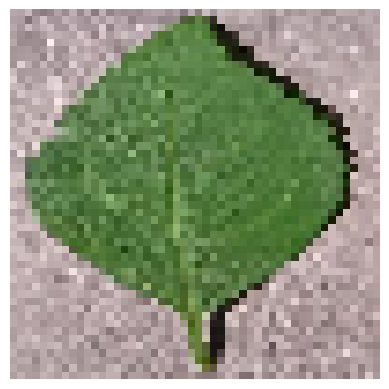

In [43]:
import matplotlib.pyplot as plt

plt.imshow(pil_image)
plt.axis('off')
plt.show()

* Convert image to array and prepare for prediction

In [45]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 50, 50, 3)


* Predict class probabilities

In [46]:
pred_proba = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_data_set.class_indices.items()}
pred_class =  target_map[pred_proba > 0.5]  

if pred_class == target_map[0]: pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 [==============================] - 0s 187ms/step
0.9998795370556763
healthy


----

## 13. Conlusions

---

- **Effective Performance**: The model showcases impressive performance, even with a relatively small dataset, highlighting its efficiency in learning from limited data.

- **Consistent Learning**: Analysis of loss and accuracy curves reveals a stable and consistent training behavior, with no signs of overfitting or underfitting, indicating a well-tuned model.

- **Accurate Predictions**: Demonstrates a strong capability to accurately predict the class of new, unseen images, confirming the model's generalization ability.

- **Data Augmentation Impact**: The application of data augmentation techniques significantly contributed to the model's robustness, allowing it to handle a variety of image orientations and scales.

- **Real-World Applicability**: The model's reliability in classifying cherry leaf diseases underlines its potential for real-world agricultural applications, offering valuable support for early disease detection and management.

- **Future Improvement Avenues**: While current results are promising, exploring more complex architectures, deeper networks, and larger datasets could further enhance model performance and reliability.